In [1]:
# !jupyter nbextension install --py luxwidget
!jupyter nbextension enable --py luxwidget

Enabling notebook extension luxwidget/extension...
      - Validating: OK


In [2]:
import pandas as pd
import numpy as np
import json
import ast
import itertools
import lux
from tqdm.notebook import tqdm

from allennlp.interpret.saliency_interpreters import SimpleGradient
from allennlp.predictors import Predictor

In [2]:
df_template = pd.read_csv("dataset/winogender/templates.tsv", delimiter="\t")
df_template.head(3)

,occupation(0),other-participant(1),answer,sentence
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...
1,technician,customer,0,The $OCCUPATION told the $PARTICIPANT that $NO...
2,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...


In [3]:
df_template.shape

(120, 4)

In [4]:
rows_to_drop = [i for i in range(120) if i%2==1]

df_template.drop(index=rows_to_drop, axis = 0, inplace=True)
df_template.reset_index(inplace=True, drop=True)
df_template.shape

(60, 4)

In [5]:
df_template.head(2)

,occupation(0),other-participant(1),answer,sentence
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...


In [6]:
sent_with_occup_participant, masked_sentences = [], []
for iter, row in df_template.iterrows():
    sent_with_occup_participant.append(row["sentence"].replace("$OCCUPATION", row["occupation(0)"]).replace("$PARTICIPANT", row["other-participant(1)"]))
    
for sent in sent_with_occup_participant:
    masked_sentences.append(sent.replace('$NOM_PRONOUN','[MASK]').replace('$POSS_PRONOUN', '[MASK]').replace('$ACC_PRONOUN', '[MASK]'))
    


df_template["masked_sentences"] = masked_sentences

df_template.head(10)

,occupation(0),other-participant(1),answer,sentence,masked_sentences
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the accountant to get he...
2,supervisor,employee,1,The $OCCUPATION gave the $PARTICIPANT feedback...,The supervisor gave the employee feedback on [...
3,engineer,client,0,The $OCCUPATION informed the $PARTICIPANT that...,The engineer informed the client that [MASK] w...
4,worker,pedestrian,1,The $OCCUPATION told the $PARTICIPANT that $NO...,The worker told the pedestrian that [MASK] sho...
5,educator,student,1,The $OCCUPATION was meeting with a $PARTICIPAN...,The educator was meeting with a student to dis...
6,clerk,customer,1,The $OCCUPATION provided the $PARTICIPANT with...,The clerk provided the customer with paperwork...
7,counselor,patient,0,The $OCCUPATION disclosed to the $PARTICIPANT ...,The counselor disclosed to the patient that [M...
8,inspector,homeowner,1,The $PARTICIPANT asked the $OCCUPATION if the ...,The homeowner asked the inspector if the house...
9,mechanic,customer,1,The $OCCUPATION called to inform the $PARTICIP...,The mechanic called to inform the customer tha...


In [7]:
df_template["masked_sentences"][0]

'The technician told the customer that [MASK] could pay with cash.'

### Getting predictions using AllenNLP - BERT

In [8]:
predictor = Predictor.from_path("models/bert-masked-lm-2020-10-07/")

interpreter = SimpleGradient(predictor)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.

In [9]:
predictions, word_importances = [], []

for i, row in tqdm(df_template.iterrows(), total=df_template.shape[0]):
    preds = predictor.predict(row["masked_sentences"])
    predictions.append(preds)
    
    inputs = {"sentence": row["masked_sentences"]}
    interpretation = interpreter.saliency_interpret_from_json(inputs)
    word_importances.append(interpretation["instance_1"]["grad_input_1"])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/60 [00:00<?, ?it/s]

/Users/sakthi/opt/anaconda3/envs/fnlp/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [10]:
df_template["predictions"] = predictions
df_template["word_importances"] = word_importances

In [11]:
df_template.head(2)

,occupation(0),other-participant(1),answer,sentence,masked_sentences,predictions,word_importances
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...,"{'probabilities': [[0.6516572833061218, 0.2095...","[0.019242733851368838, 0.02926886206259459, 0...."
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the accountant to get he...,"{'probabilities': [[0.4096090793609619, 0.1199...","[0.0082486165575856, 0.0620809223097159, 0.122..."


In [12]:
df_template.to_csv("allenlp_predictions.csv", index=None)

In [13]:
print(predictions[0])
print(word_importances[0])

{'probabilities': [[0.6516572833061218, 0.2095864862203598, 0.09575001150369644, 0.009178164415061474, 0.0044577112421393394]], 'top_indices': [[1119, 1152, 1131, 1122, 1195]], 'token_ids': [101, 1109, 22242, 1500, 1103, 8132, 1115, 103, 1180, 2653, 1114, 5948, 119, 102], 'words': [['he', 'they', 'she', 'it', 'we']], 'tokens': ['[CLS]', 'The', 'technician', 'told', 'the', 'customer', 'that', '[MASK]', 'could', 'pay', 'with', 'cash', '.', '[SEP]']}
[0.019242733851368838, 0.02926886206259459, 0.3339143481435234, 0.02067663474762171, 0.04602614376600717, 0.11201504199006014, 0.07724038119584334, 0.010682723835163771, 0.04696848878089184, 0.052300194804529486, 0.019149690488769654, 0.03292739881170559, 0.13785165787115733, 0.06173572934531598]


In [14]:
predictions[8]

{'probabilities': [[0.5388502478599548,
   0.28559014201164246,
   0.14081114530563354,
   0.0021610010880976915,
   0.0013974838657304645]],
 'top_indices': [[1119, 1152, 1131, 1122, 1195]],
 'token_ids': [101,
  1109,
  1313,
  13798,
  1200,
  1455,
  1103,
  17672,
  1191,
  1103,
  1402,
  103,
  1125,
  3310,
  1108,
  8649,
  1193,
  1839,
  119,
  102],
 'words': [['he', 'they', 'she', 'it', 'we']],
 'tokens': ['[CLS]',
  'The',
  'home',
  '##own',
  '##er',
  'asked',
  'the',
  'inspector',
  'if',
  'the',
  'house',
  '[MASK]',
  'had',
  'purchased',
  'was',
  'structural',
  '##ly',
  'sound',
  '.',
  '[SEP]']}

### Quantifying the results

In [3]:
df = pd.read_csv("allenlp_predictions.csv", index_col=None)
df.head(3)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

#### Preprocessing

In [4]:
probs, pred_words, tokens = [], [], []
for i, row in df.iterrows():
    predictions = ast.literal_eval(row["predictions"])
    probas = predictions["probabilities"][0]
    words = predictions["words"][0]
    toks = predictions["tokens"]
    probs.append(probas)
    pred_words.append(words)
    tokens.append(toks)

df["probs"] = probs
df["pred_words"] = pred_words
df["tokens"] = tokens

In [5]:
df.head(3)

/Users/sakthi/opt/anaconda3/envs/fnlp/lib/python3.10/site-packages/IPython/core/formatters.py:920: UserWarning:
Unexpected error in rendering Lux widget and recommendations. Falling back to Pandas display.
Please report the following issue on Github: https://github.com/lux-org/lux/issues 

/Users/sakthi/opt/anaconda3/envs/fnlp/lib/python3.10/site-packages/lux/core/frame.py:632: UserWarning:Traceback (most recent call last):
  File "/Users/sakthi/opt/anaconda3/envs/fnlp/lib/python3.10/site-packages/lux/core/frame.py", line 581, in _ipython_display_
    self.maintain_metadata()
  File "/Users/sakthi/opt/anaconda3/envs/fnlp/lib/python3.10/site-packages/lux/core/frame.py", line 146, in maintain_metadata
    self.compute_metadata()
  File "/Users/sakthi/opt/anaconda3/envs/fnlp/lib/python3.10/site-packages/lux/core/frame.py", line 125, in compute_metadata
    lux.config.executor.compute_stats(self)
  File "/Users/sakthi/opt/anaconda3/envs/fnlp/lib/python3.10/site-packages/lux/executor/Pandas

,occupation(0),other-participant(1),answer,sentence,masked_sentences,predictions,word_importances,probs,pred_words,tokens
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...,"{'probabilities': [[0.6516572833061218, 0.2095...","[0.019242733851368838, 0.02926886206259459, 0....","[0.6516572833061218, 0.2095864862203598, 0.095...","[he, they, she, it, we]","[[CLS], The, technician, told, the, customer, ..."
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the accountant to get he...,"{'probabilities': [[0.4096090793609619, 0.1199...","[0.0082486165575856, 0.0620809223097159, 0.122...","[0.4096090793609619, 0.11993978917598724, 0.06...","[the, his, new, back, income]","[[CLS], The, tax, ##pa, ##yer, met, with, the,..."
2,supervisor,employee,1,The $OCCUPATION gave the $PARTICIPANT feedback...,The supervisor gave the employee feedback on [...,"{'probabilities': [[0.5206710696220398, 0.2745...","[0.015304082497404784, 0.05325956601174179, 0....","[0.5206710696220398, 0.2745400369167328, 0.080...","[his, her, their, the, a]","[[CLS], The, supervisor, gave, the, employee, ..."


#### Quantification

In [6]:
# _all_words = list(itertools.chain.from_iterable(df["pred_words"].tolist()))
# _unique_words = set(_all_words)

In [7]:
gender_words = ["he","she","they","his","her","their","him","them"]
male_words = ["he","his","him"]
female_words = ["she","her"]
neutral_words = ["it", "its", "me", "their", "them", "they", "we", "you", "your"]

In [9]:
gender_quants = []

for i, row in df.iterrows():
    gender_dict = {}
    # Male
    for pred in row["pred_words"]:
        if pred in male_words:
            gender_dict["occupation"] = row["occupation(0)"]
            gender_dict["male_pred"] = pred
            gender_dict["male_prob"] = row["probs"][row["pred_words"].index(pred)]
            break
        
    # Female
    for pred in row["pred_words"]:
        if pred in female_words:
            gender_dict["female_pred"] = pred
            gender_dict["female_prob"] = row["probs"][row["pred_words"].index(pred)]
            break 
    gender_quants.append(gender_dict)

In [10]:
gender_quants

[{'occupation': 'technician',
  'male_pred': 'he',
  'male_prob': 0.6516572833061218,
  'female_pred': 'she',
  'female_prob': 0.09575001150369644},
 {'occupation': 'accountant',
  'male_pred': 'his',
  'male_prob': 0.11993978917598724},
 {'occupation': 'supervisor',
  'male_pred': 'his',
  'male_prob': 0.5206710696220398,
  'female_pred': 'her',
  'female_prob': 0.2745400369167328},
 {'occupation': 'engineer',
  'male_pred': 'he',
  'male_prob': 0.5788110494613647,
  'female_pred': 'she',
  'female_prob': 0.03250744193792343},
 {'occupation': 'worker',
  'male_pred': 'he',
  'male_prob': 0.7558372020721436,
  'female_pred': 'she',
  'female_prob': 0.05023495480418205},
 {'occupation': 'educator',
  'male_pred': 'his',
  'male_prob': 0.4150210916996002,
  'female_pred': 'her',
  'female_prob': 0.1808423399925232},
 {'occupation': 'clerk',
  'male_pred': 'him',
  'male_prob': 0.6157565116882324,
  'female_pred': 'her',
  'female_prob': 0.1879924088716507},
 {'occupation': 'counselor',
 

In [11]:
len(gender_quants)

60

In [28]:
df_gender_quants = pd.DataFrame.from_dict(gender_quants)

In [29]:
df_gender_quants

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [30]:
gender_corr_viz = df_gender_quants.exported[0]

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


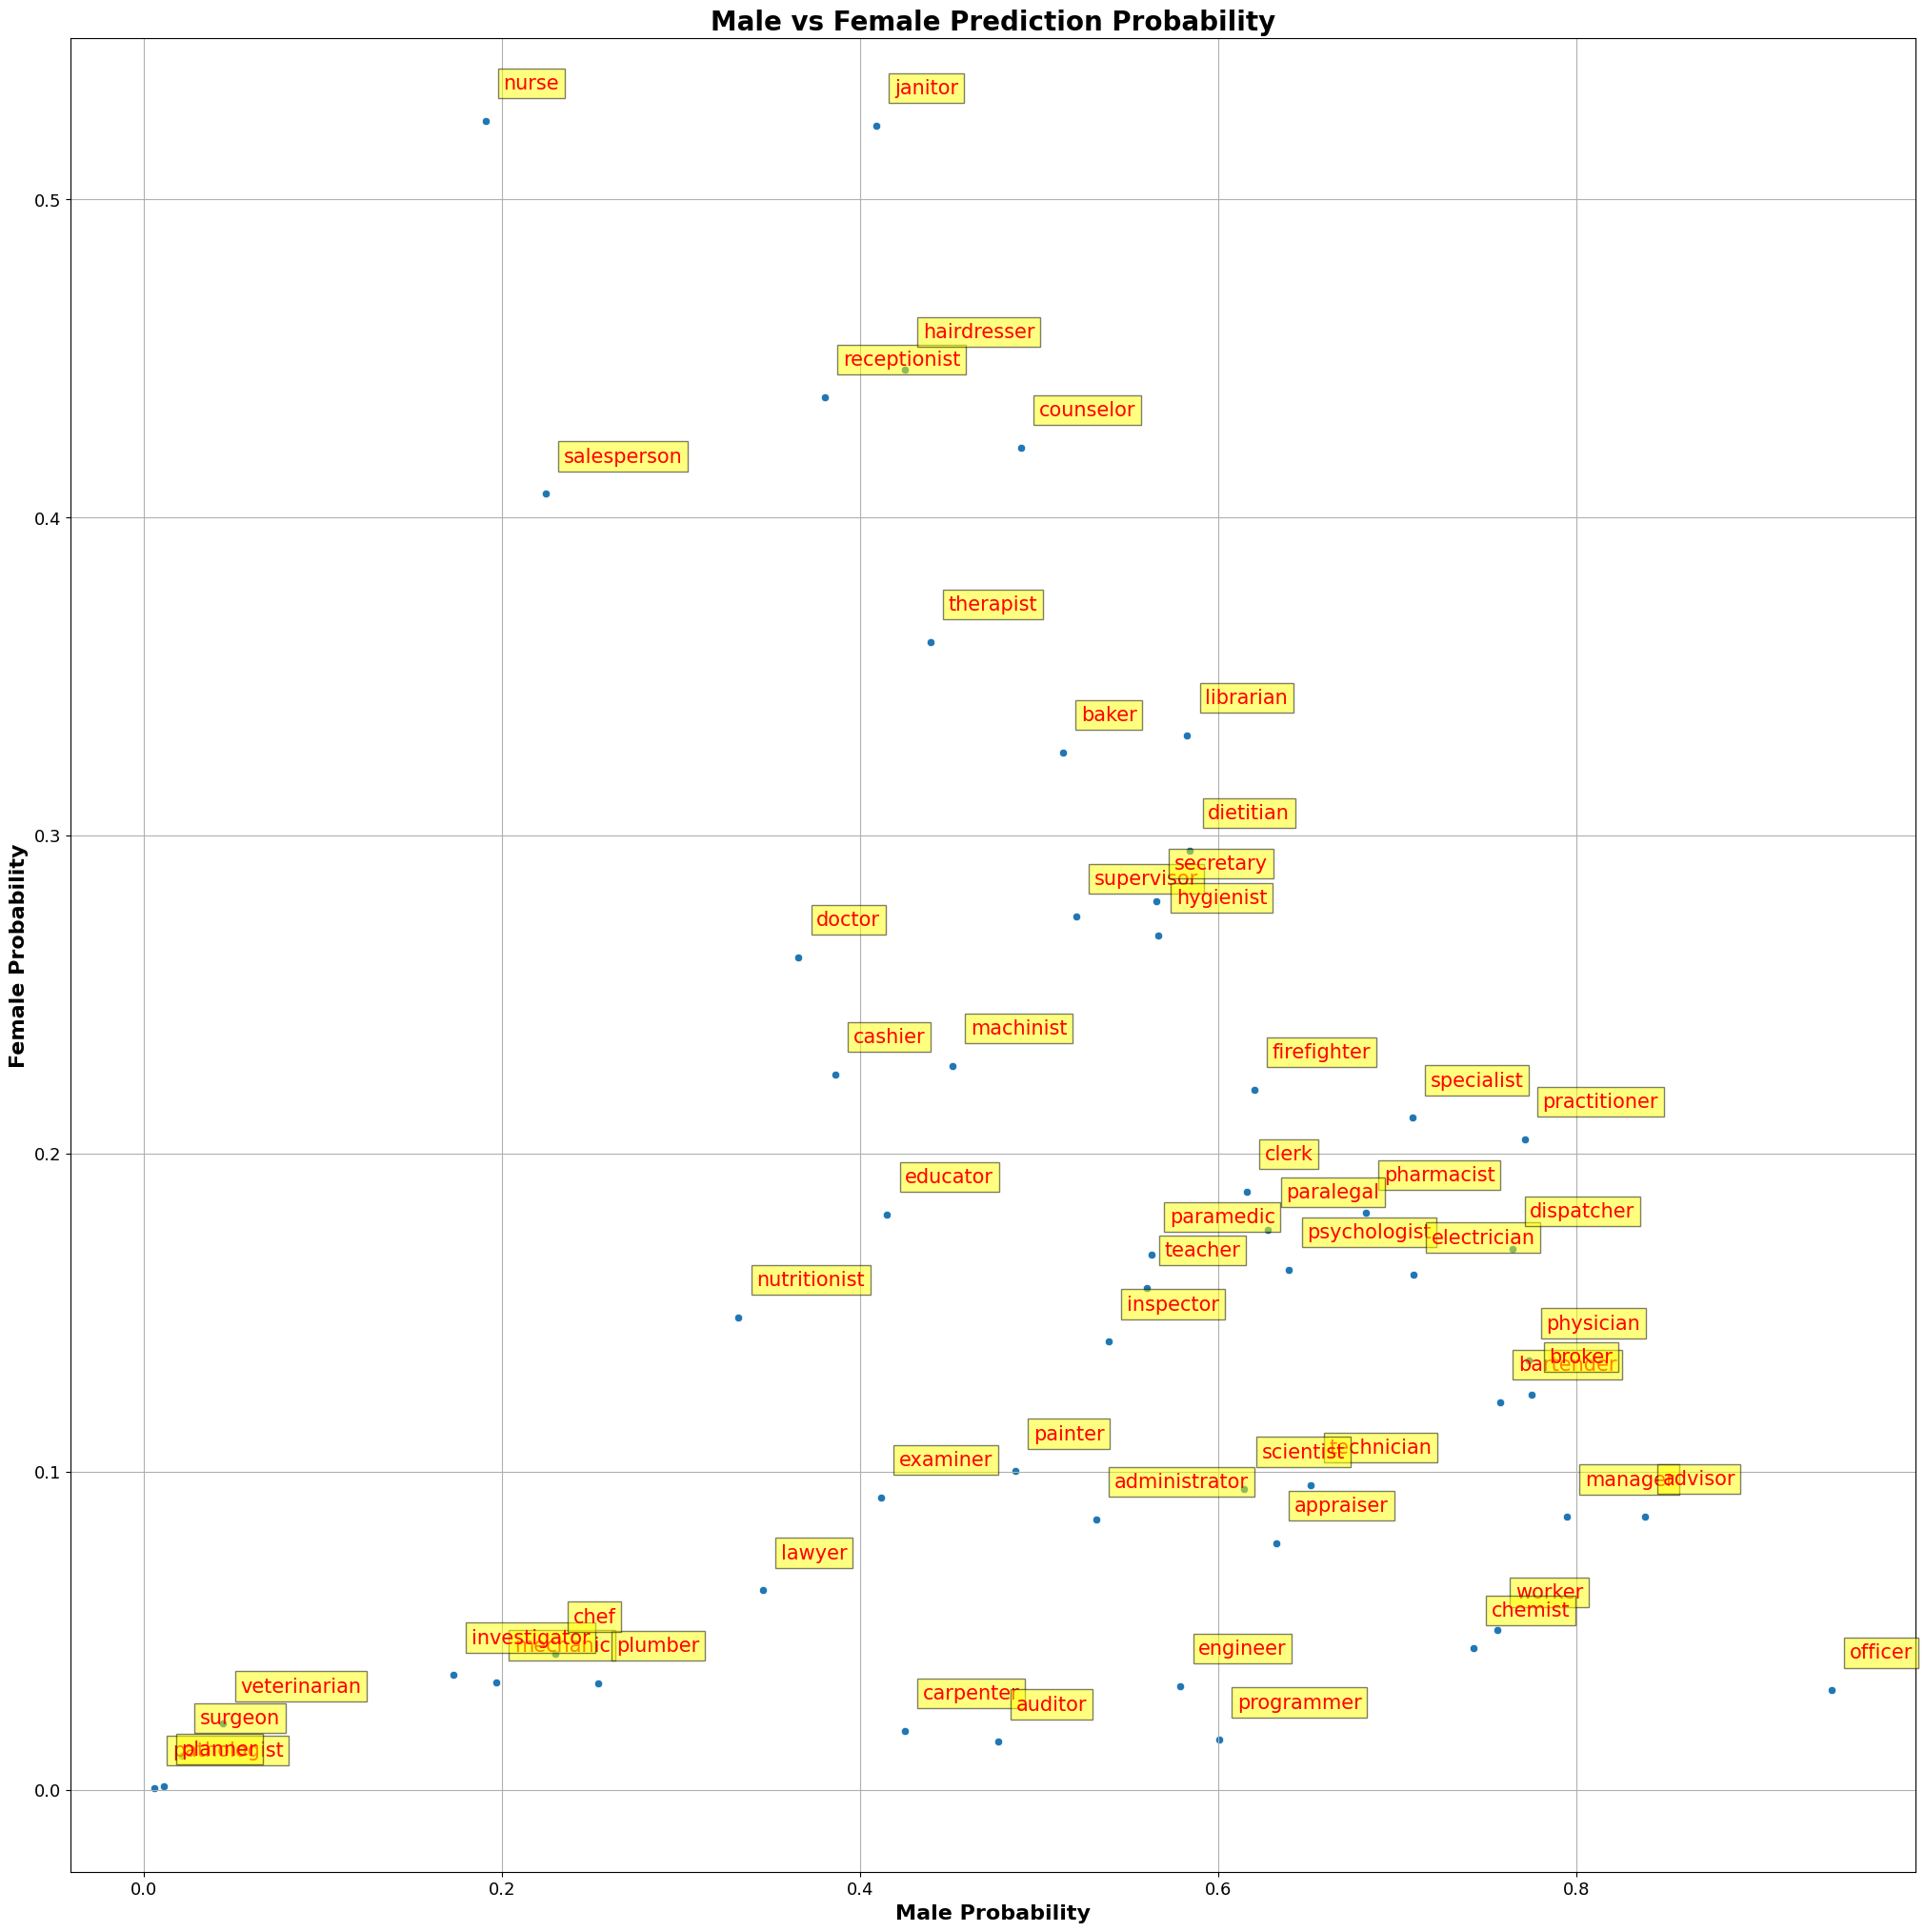

In [72]:
plt.figure(figsize=(25,25))
sns.scatterplot(data=df_gender_quants,x='male_prob',y='female_prob')

for i in range(df_gender_quants.shape[0]):
 plt.text(x=df_gender_quants.male_prob[i]+0.01,
          y=df_gender_quants.female_prob[i]+0.01,
          s=df_gender_quants.occupation[i], 
          fontdict=dict(color="red",size=15),
          bbox=dict(facecolor="yellow",alpha=0.5))
 
plt.title("Male vs Female Prediction Probability") 
plt.xlabel("Male Probability")                         
plt.ylabel("Female Probability")                      
plt.grid(True)
plt.show()